In [1]:
import os
import sys
import re
import glob
import h5py
import numpy as np
import scipy
import re
import pickle
import psutil
from time import time
try:
    from itertools import zip_longest
except ImportError:
    from itertools import izip_longest as zip_longest
from astropy.table import Table, vstack
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [3]:
# Galacticus library
lib_path = '/gpfs/mira-fs0/projects/DarkUniverse_esp/dkorytov/data/Galacticus/{}/galaxy_library/'
gfile_name = '{}_mod.hdf5'
z_ranges = ("0_1", "1_3")
z_types = ("low_z", "high_z")
steps_list = ("499 487 475 464 453 442 432 421 411 401 392 382 373 365 355 347 338 331 323 315 307 300 293 286 279 272 266 259 253 247",\
              "241 235 230 224 219 213 208 203 198 194 189 184 180 176 171 167 163 159 155 151 148 144 141 137 134 131 127 124 121")
key_groups = ['galaxyProperties/emissionLines']
# Galacticus files
file_path = '/gpfs/mira-fs0/projects/DarkUniverse_esp/kovacs/GalacticusFiles/AlphaQv3LB_dust_ELG{}'
path_opts = ['', '_hiz']
file_dir = 'AlphaQv3LB_{}*/nbody*/AlphaQv3LB_*'
file_groups = ['cori', 'split']
#file_groups = ['trees', 'cori', 'long', 'split']
file_name = 'galacticus_*.hdf5'
hdf5grp = 'Outputs'
fkey_groups = ['totalLineLuminosity', 'spheroidLineLuminosity', 'diskLineLuminosity']
exclude_list = ['contam', 'observed']

In [4]:
def get_table(f, keys=None): 
    t = Table()
    keys = list(f.keys()) if keys is None else keys
    for k in keys:
        t[k] = f[k]
    
    return t

def get_data(fh, key_groups, exclude=[]):
    data = Table()
    for s in key_groups:
        if s in fh.keys():
            t = get_table(fh[s])
        else:
            matching_keys = [k for k in fh.keys() if s in k]
            for x in exclude:
                matching_keys = [k for k in matching_keys if x not in k]
            t = get_table(fh, keys=matching_keys)
        data = vstack([data, t])
        
    return data

def get_filelist(path, path_opt='', filedir=file_dir, file_groups=file_groups):
    file_list = []
    for grp in file_groups:
        glob_name = os.path.join(path.format(path_opt), filedir.format(grp), file_name)
        print('Using glob_name {}'.format(glob_name))
        file_list.append(glob.glob(glob_name))
        
    return [item for sublist in file_list for item in sublist]

In [5]:
def get_step_data(data, z_type, steps, key_groups):
    for step in steps.split():
        hpx_file = os .path.join(lib_path.format(z_type), gfile_name.format(step))
        fh = h5py.File(hpx_file, 'r')
        data[step] = get_data(fh, key_groups)
    
    return data

def get_file_data(data, gal_file, path_opt, fkey_groups, exclude=exclude_list):
    fh = h5py.File(gal_file, 'r')
    for k in fh[hdf5grp].keys():
        table = get_data(fh[hdf5grp][k]['nodeData'], fkey_groups, exclude=exclude)
        key = k + path_opt
        data[key] = vstack([data[key], table]) if key in data.keys() else table

    fh.close()
    return data

In [6]:
def get_all_lib_data(z_types, steps_list, key_groups):
    data =   {}
    for z_type, steps in zip(z_types,steps_list):
        data = get_step_data(data, z_type, steps, key_groups)
        
    print(data.keys(), data['499'].keys())
    return data

def get_all_file_data(path, path_opts, file_dir, fkey_groups, file_groups=file_groups):
    data = {}
    for path_opt in path_opts:
        files = get_filelist(path, path_opt=path_opt, filedir=file_dir, file_groups=file_groups)
        print('Reading {} files'.format(len(files)))
        for file in files:
            print('Processing {}'.format(os.path.basename(file)))
            data = get_file_data(data, file, path_opt, fkey_groups, exclude=exclude_list)
        
    return data

def rename_output_keys(data):
    old_keys = sorted(data.keys())
    for k in old_keys:
        if 'Output' in k:
            if len(data[k].keys()) > 0:
                zval = data[k].keys()[0].split(':z')[-1]
                if zval not in data.keys():
                    data[zval] = data.pop(k)
                elif 'hiz' in k:
                    data[zval+'_hiz'] = data.pop(k)
                else:
                    data[zval+'_hiz'] = data.pop(zval)
                    data[zval] = data.pop(k)
                
    print('New keys: {}'.format(data.keys()))
    
    return data

In [7]:
data = get_all_lib_data(z_types, steps_list, key_groups)

/opt/anaconda3x/lib/python3.7/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


dict_keys(['499', '487', '475', '464', '453', '442', '432', '421', '411', '401', '392', '382', '373', '365', '355', '347', '338', '331', '323', '315', '307', '300', '293', '286', '279', '272', '266', '259', '253', '247', '241', '235', '230', '224', '219', '213', '208', '203', '198', '194', '189', '184', '180', '176', '171', '167', '163', '159', '155', '151', '148', '144', '141', '137', '134', '131', '127', '124', '121']) ['diskLineLuminosity:balmerAlpha6563:rest', 'diskLineLuminosity:balmerAlpha6563:rest:contam_nitrogenII6584', 'diskLineLuminosity:balmerBeta4861:rest', 'diskLineLuminosity:nitrogenII6584:rest', 'diskLineLuminosity:oxygenII3726:rest', 'diskLineLuminosity:oxygenII3729:rest', 'diskLineLuminosity:oxygenIII4959:rest', 'diskLineLuminosity:oxygenIII5007:rest', 'diskLineLuminosity:sulfurII6716:rest', 'diskLineLuminosity:sulfurII6731:rest', 'spheroidLineLuminosity:balmerAlpha6563:rest', 'spheroidLineLuminosity:balmerAlpha6563:rest:contam_nitrogenII6584', 'spheroidLineLuminosity:

In [8]:
def get_stats(data, prnt=[]):
    stats = {}
    for step in data.keys():
        stats[step] = {}
        for k in data[step].keys():
            stats[step][k + '_min'] = np.min(data[step][k])
            stats[step][k + '_max'] = np.max(data[step][k])
            
        for p in prnt:
            print('step {}: {}_max={:.3g}'.format(step, p, stats[step][p + '_max']))
            
    return stats

In [9]:
bkeys = [k for k in data['499'].keys() if 'balmer' in k and 'contam' not in k]
print(bkeys)
stats = get_stats(data)
steps = list(map(int, list(stats.keys())))
print(steps[::-1])

['diskLineLuminosity:balmerAlpha6563:rest', 'diskLineLuminosity:balmerBeta4861:rest', 'spheroidLineLuminosity:balmerAlpha6563:rest', 'spheroidLineLuminosity:balmerBeta4861:rest', 'totalLineLuminosity:balmerAlpha6563:rest', 'totalLineLuminosity:balmerBeta4861:rest']
[121, 124, 127, 131, 134, 137, 141, 144, 148, 151, 155, 159, 163, 167, 171, 176, 180, 184, 189, 194, 198, 203, 208, 213, 219, 224, 230, 235, 241, 247, 253, 259, 266, 272, 279, 286, 293, 300, 307, 315, 323, 331, 338, 347, 355, 365, 373, 382, 392, 401, 411, 421, 432, 442, 453, 464, 475, 487, 499]


In [13]:
#AB luminosity (4.4659e13 W/Hz) for filters
# solar luminosities:  3.839e26 W for line luminosities
watts='(W)'
ergs='(ergs/s)'
lsun2watts=3.839e26
lsun2ergspersec=3.839e33
figx=15
figy=5
keys=['balmerAlpha6563', 'balmerBeta4861']
components = ['disk', 'spheroid', 'total']
prop = 'LineLuminosity'
def plot_stats(stats, keys, components, val='max', prop=prop, unit='', factor=1,
               colors=['r','g','black'], files=False,
               nrows=1, sharey=False, sharex=True, plotdir='./pdffiles', fname='_{}_vs_{}'):
    ncols = len(keys)
    fn = 'Files' if files else 'Lib'
    xlabel = 'z' if files else 'Step'
    #select numerical keys only (remove duplicate hiz keys)
    xkeys = sorted([k for k in stats.keys() if all([t.isnumeric() for t in k.split('.')])])
    fig, ax_all = plt.subplots(nrows, ncols, figsize=(figx, figy*nrows), sharey=sharey,
                               sharex=sharex)
    steps = list(map(float, xkeys)) if files else list(map(int, xkeys))
    for ax, key in zip(ax_all, keys):
        for color, component in zip(colors, components):
            values=[]
            for step, xkey in zip(steps, xkeys):
                dkeys = [k for k in stats[xkey].keys() if component in k and val in k and key in k]
                if len(dkeys)>0:
                    dkey=dkeys[0]
                    values.append(stats[xkey][dkey]*factor)
                else:
                    print('No match for step {}; {} {} {}'.format(step, key, component, val))
                    values.append(np.nan)
                    
            ax.plot(steps, values, color=color, label=component)
    
        ax.set_xlabel(xlabel)
        ax.set_ylabel(' '.join([val, prop, unit]))
        ax.legend(loc='best', numpoints=1, title=key)
        
    save_fig(fig, plotdir, fn + fname.format(prop, 'step'))
    return
                                    
def save_fig(fig, plotdir, figname, title='', hspace=.05, wspace=.2):
    fig.suptitle(title, size=16)
    fig.tight_layout()
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    fig.subplots_adjust(top=0.94)
    file_type = '.pdf' if 'pdf' in plotdir else '.png'
    figname = os.path.join(plotdir, re.sub('_+', '_', figname) + file_type)
    print('  Saving {}\n'.format(figname))
    fig.savefig(figname, bbox_inches='tight')
    #plt.close(fig)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


  Saving ./pdffiles/Lib_LineLuminosity_vs_step.pdf



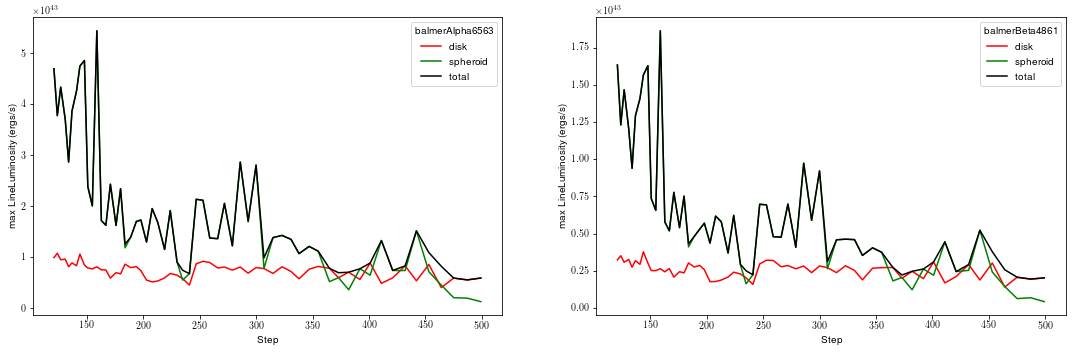

In [14]:
#print(stats['499']['diskLineLuminosity:balmerAlpha6563:rest_max'])
#print([k for k in stats['121'].keys() if 'balmer' in k and 'contam' not in k])
plot_stats(stats, keys, components, factor=lsun2ergspersec, unit=ergs)

In [ ]:
def plot_dist(data, q, factor=lsun2ergspersec, unit=ergs, plotdir='./pdffiles', fname='_{}_vs_{}'):
    
    

In [157]:
gdata = get_all_file_data(file_path, path_opts, file_dir, fkey_groups, file_groups=file_groups)

Using glob_name /gpfs/mira-fs0/projects/DarkUniverse_esp/kovacs/GalacticusFiles/AlphaQv3LB_dust_ELG/AlphaQv3LB_cori*/nbody*/AlphaQv3LB_*/galacticus_*.hdf5
Using glob_name /gpfs/mira-fs0/projects/DarkUniverse_esp/kovacs/GalacticusFiles/AlphaQv3LB_dust_ELG/AlphaQv3LB_split*/nbody*/AlphaQv3LB_*/galacticus_*.hdf5
Reading 224 files
Processing galacticus_AlphaQv3LB_102_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_188_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_215_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_135_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_115_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_19_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_104_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_202_nbody_AlphaQ

Processing galacticus_AlphaQv3LB_34_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_31_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_39_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_223_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_230_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_42_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_52_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_227_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_248_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_53_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_245_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_Alpha

Processing galacticus_AlphaQv3LB_split_250_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_189_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_249_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_93_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_78_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_5_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_242_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_65_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_234_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_214_nbody_AlphaQ_z1.1_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_58_nbody_AlphaQ_

Processing galacticus_AlphaQv3LB_cori_130_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_cori_136_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_cori_174_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_cori_143_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_cori_34_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_cori_207_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_cori_119_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_cori_39_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_cori_31_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_cori_182_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_A

Processing galacticus_AlphaQv3LB_split_154_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_142_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_17_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_186_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_211_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_144_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_1_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_157_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_179_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_138_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing ga

Processing galacticus_AlphaQv3LB_split_59_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_28_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_27_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_56_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_55_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_88_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_74_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5
Processing galacticus_AlphaQv3LB_split_80_nbody_AlphaQ_z1.0-3.0_BH_SDSS_LSST_BV_ELG_SEDval44.hdf5


In [159]:
gdata = rename_output_keys(gdata)


New keys: dict_keys(['1.1069', '0.6948', '2.2524', '0.6557', '2.1703', '0.6184', '2.0923', '0.5777', '2.0180', '0.5391', '1.9472', '0.5022', '1.8797', '0.4714', '1.7994', '0.4337', '1.7384', '0.4017', '1.6800', '0.3636', '1.6104', '3.0361', '1.0552', '0.3347', '1.5443', '0.3035', '1.4938', '0.2705', '1.4334', '0.2423', '1.3759', '0.2123', '1.3210', '0.1837', '1.2584', '0.1538', '1.2088', '0.1279', '1.1520', '0.1008', '1.1069_hiz', '0.0749', '1.0552_hiz', '2.9412', '1.0060', '0.0502', '1.0060_hiz', '0.0245', '0.0000', '2.8506', '0.9591', '2.7361', '0.9143', '2.6545', '0.8646', '2.5765', '0.8240', '2.4775', '0.7788', '2.4068', '0.7358', '2.3168'])


In [160]:
gstats = get_stats(gdata)

In [161]:
xkeys = sorted([k for k in gstats.keys() if all([t.isnumeric() for t in k.split('.')])])
print(xkeys)
steps = list(map(float, xkeys))
print(steps)

['0.0000', '0.0245', '0.0502', '0.0749', '0.1008', '0.1279', '0.1538', '0.1837', '0.2123', '0.2423', '0.2705', '0.3035', '0.3347', '0.3636', '0.4017', '0.4337', '0.4714', '0.5022', '0.5391', '0.5777', '0.6184', '0.6557', '0.6948', '0.7358', '0.7788', '0.8240', '0.8646', '0.9143', '0.9591', '1.0060', '1.0552', '1.1069', '1.1520', '1.2088', '1.2584', '1.3210', '1.3759', '1.4334', '1.4938', '1.5443', '1.6104', '1.6800', '1.7384', '1.7994', '1.8797', '1.9472', '2.0180', '2.0923', '2.1703', '2.2524', '2.3168', '2.4068', '2.4775', '2.5765', '2.6545', '2.7361', '2.8506', '2.9412', '3.0361']
[0.0, 0.0245, 0.0502, 0.0749, 0.1008, 0.1279, 0.1538, 0.1837, 0.2123, 0.2423, 0.2705, 0.3035, 0.3347, 0.3636, 0.4017, 0.4337, 0.4714, 0.5022, 0.5391, 0.5777, 0.6184, 0.6557, 0.6948, 0.7358, 0.7788, 0.824, 0.8646, 0.9143, 0.9591, 1.006, 1.0552, 1.1069, 1.152, 1.2088, 1.2584, 1.321, 1.3759, 1.4334, 1.4938, 1.5443, 1.6104, 1.68, 1.7384, 1.7994, 1.8797, 1.9472, 2.018, 2.0923, 2.1703, 2.2524, 2.3168, 2.4068, 2.

['0.0000', '0.0245', '0.0502', '0.0749', '0.1008', '0.1279', '0.1538', '0.1837', '0.2123', '0.2423', '0.2705', '0.3035', '0.3347', '0.3636', '0.4017', '0.4337', '0.4714', '0.5022', '0.5391', '0.5777', '0.6184', '0.6557', '0.6948', '0.7358', '0.7788', '0.8240', '0.8646', '0.9143', '0.9591', '1.0060', '1.0552', '1.1069', '1.1520', '1.2088', '1.2584', '1.3210', '1.3759', '1.4334', '1.4938', '1.5443', '1.6104', '1.6800', '1.7384', '1.7994', '1.8797', '1.9472', '2.0180', '2.0923', '2.1703', '2.2524', '2.3168', '2.4068', '2.4775', '2.5765', '2.6545', '2.7361', '2.8506', '2.9412', '3.0361']
No match for step 1.152; balmerAlpha6563 total max
No match for step 1.2088; balmerAlpha6563 total max
No match for step 1.2584; balmerAlpha6563 total max
No match for step 1.321; balmerAlpha6563 total max
No match for step 1.3759; balmerAlpha6563 total max
No match for step 1.4334; balmerAlpha6563 total max
No match for step 1.4938; balmerAlpha6563 total max
No match for step 1.5443; balmerAlpha6563 total

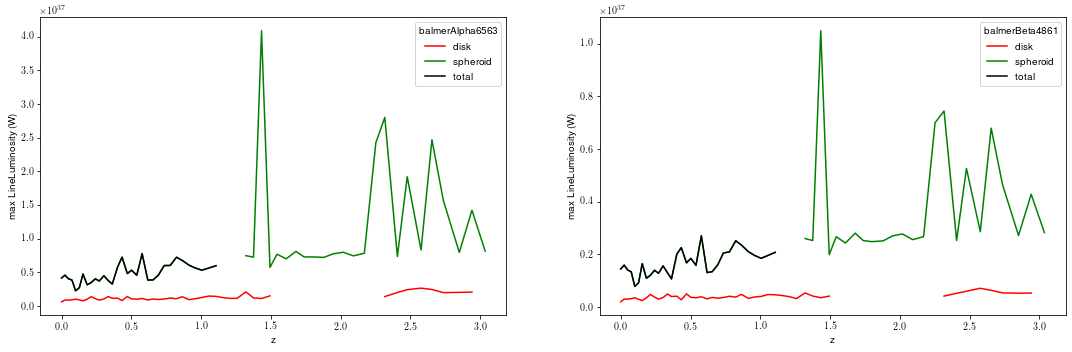

In [162]:
plot_stats(gstats, keys, components, factor=lsun2watts, unit=watts, files=True)
